# Cooperative optimization for data science

## Load the data

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import cvxpy as cp
import math


In [234]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)

Text(0.5, 1.0, 'Data visualization')

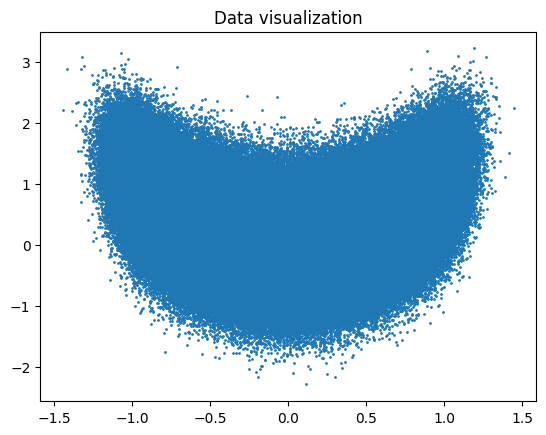

In [235]:
plt.scatter(x, y, s=1)
plt.title("Data visualization")

## Define the parameters

In [236]:
n = 100 # x_selected
m = 10
a = 5
sigma = 0.5
nu = 1

In [237]:
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind]
y_selected = [y[i] for i in ind]

Text(0, 0.5, 'y')

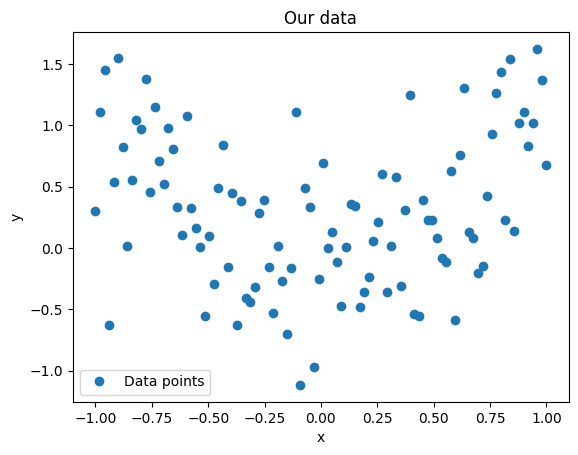

In [238]:
# Plot the selected points

plt.plot(x[:n],y[:n],'o', label = "Data points")
#plt.plot(x_selected,y_selected,'o',label="Selected points")
plt.title("Our data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

<h2> Utils

In [239]:
def kernel(x, y):
    K = np.exp(-np.linalg.norm(x - y)**2)
    return K

In [240]:
def matrix_K(x, y):
    p = len(x)
    q = len(y)
    K = np.zeros((p,q))
    for i in range(p):
        for j in range(q):
            K[i][j] = kernel(x[i],y[j])
    return K

In [241]:
def plot_f(nt, alpha_method, title, method):
    x_prime = np.linspace(-1, 1, nt)
    f_values_alpha = np.zeros_like(x_prime)

    # Compute the function values for each point in the grid
    for i, xi in enumerate(x_prime):
        # Evaluate the function at the current grid point
        f_values_alpha[i] = sum([alpha_method[j] * kernel(xi, x_selected[j]) for j in range(m)])

    # Plot the obtained function
    plt.plot(x[:n],y[:n], 'o', label = 'Data')
    #plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
    plt.plot(x_prime, f_values_alpha_star, label='f reconstructed alpha star')
    plt.plot(x_prime, f_values_alpha, linestyle='--', label=f'f reconstructed using {method}')
    plt.xlabel('x')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

We define the communication graph below :

In [252]:
# cycle
# w = [[1/3, 1/3, 0, 0, 1/3], [1/3, 1/3, 1/3, 0, 0], [0, 1/3, 1/3, 1/3, 0], [0, 0, 1/3, 1/3, 1/3], [1/3, 0, 0, 1/3, 1/3]]

# fully connected
w = [[1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5]]

# line graph
# w = [[1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 0, 1, 1]]

# small-world graph
# w = [[0, 1/2, 0, 0, 1/2], [1, 0, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 0, 1], [1, 0, 0, 1, 0]]

# test
# w = [[1/4, 0, 1/4, 1/4, 1/4], [1/4, 1, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4]]

# Decentralized gradient descent

<h2> Compute optimal $\alpha*$ using linear algebra

In [253]:
# Construct the problem.
Knn = matrix_K(x[:n], x[:n])
Kmm = matrix_K(x_selected,x_selected)
Knm = matrix_K(x[:n],x_selected)

In [254]:
np.linalg.det(Kmm + Knm.T@Knm/(sigma**2))

1.1023000440527868e-25

In [255]:
alpha_star = np.linalg.solve((sigma**2)*Kmm + Knm.T@Knm + nu*np.eye(m),Knm.T@y[:n])

In [256]:
alpha_star

array([ 0.31900503,  0.66988957, -0.55188844, -0.53370457,  0.64144207,
        0.66908585, -0.05193184, -0.05216289,  0.02001046,  0.08469725])

Reconstruct f using $\alpha^{*}$

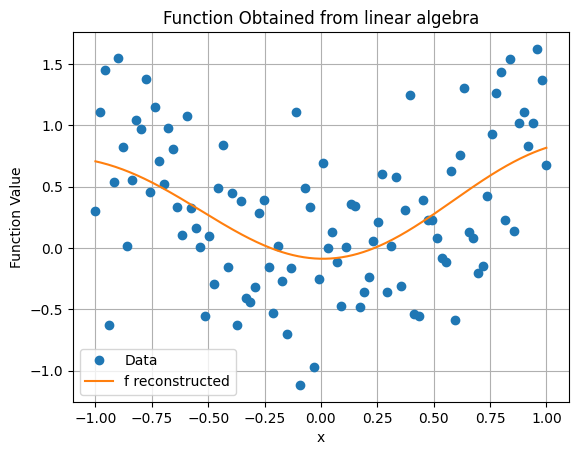

In [257]:
nt = 250
x_prime = np.linspace(-1, 1, nt)
alpha = alpha_star

f_values_alpha_star = np.zeros_like(x_prime)

# Compute the function values for each point in the grid
for i, xi in enumerate(x_prime):
    # Evaluate the function at the current grid point
    f_values_alpha_star[i] = sum([alpha[j] * kernel(xi, x_selected[j]) for j in range(m)])

# Plot the obtained function
plt.plot(x[:n],y[:n], 'o', label = 'Data')
#plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
plt.plot(x_prime, f_values_alpha_star, label='f reconstructed')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.title('Function Obtained from linear algebra')
plt.legend()
plt.grid(True)
plt.show()

<h2> Decentralized gradient descent (DGD)

In this part we will need the value of $\alpha^{*}$ found above to compute the optimality gap at each iteration

For each agent $a \in \{1,...5\}$ we define the following function:

\begin{equation*} g_{a}(\alpha) = \frac{\sigma^2}{5}\frac{1}{2}\alpha^{T}K_{mm}\alpha + \frac{1}{2}\vert\vert y - K_{(i)m}\alpha\vert\vert + \frac{nu}{10}\vert\vert \alpha \vert \vert^{2}_{2} \end{equation*}

In [258]:
K = matrix_K(x[:n], x[:n])
Kmm = K[ind,:][:,ind]
agents = np.array_split(np.random.choice(np.array(range(n)),size=n, replace=False),a)

Chose learning rate :

In [259]:
m_a = np.zeros(a)
L_a = np.zeros(a)

for j in range(a):
    nabla_g = Kmm/5
    for i in agents[j]:
        Kim = K[i,:][ind]
        nabla_g += Kim@Kim.T/(sigma**2)
    eigenval, _ = np.linalg.eig(nabla_g)
    L_a[j] = np.max(np.abs(eigenval))
    m_a[j] = np.min(np.abs(eigenval))
L = np.max(L_a)
#m = np.min(m_a)


In [260]:
print("L = ", L)
#print("m = ", m)

L =  3887.6987803472416


In [261]:
def compute_local_gradient(alpha, a, sigma, y, K, M, agents):
    
    Kmm = K[M,:][:,M]
    
    somme = np.zeros(len(alpha))
    for i in agents[a]:
        Kim = K[i,:][M]
        somme += (y[i] - Kim@alpha)*Kim.T
        
    return (sigma**2)*Kmm@alpha/5  - somme + (nu/len(agents))*alpha

In [262]:
def DGD(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star):

    nb_agents = a
    
    m = len(ind)
    
    opt_gap = np.zeros((num_iterations,nb_agents)) # optimality gap
    
    #alpha = np.random.normal(size=(nb_agents, m)) # randomly initialize the value of alpha
    alpha = np.zeros((nb_agents, m))
    
    for k in range(num_iterations):
        new_alpha = alpha.copy()
        
        # communicate the values of alpha between all the agents
        communicated = w@alpha
        
        for agent_id in range(nb_agents):
            grad = compute_local_gradient(alpha[agent_id], agent_id, sigma, y, K, ind, agents)
            new_alpha[agent_id] = communicated[agent_id] - learning_rate*grad
    
        alpha = new_alpha.copy()
        opt_gap[k] = np.linalg.norm(alpha - alpha_star,axis=1)

        
    return alpha, opt_gap

In [268]:
num_iterations = 10000
K = matrix_K(x[:n],x[:n])
step_size = 0.01
alpha_dgd, opt_gap_dgd = DGD(num_iterations, agents, ind, K, y[:n], step_size, sigma, alpha_star)
#alpha_dgd_1000, _ = DGD(1000, agents, ind, K, y[:n], step_size, sigma, true_alpha_linalg)

In [269]:
alpha_dgd= np.mean(alpha_dgd,axis=0)
#alpha_dgd_1000 = np.mean(alpha_dgd_1000,axis=0)

## Visualize the functions obtained

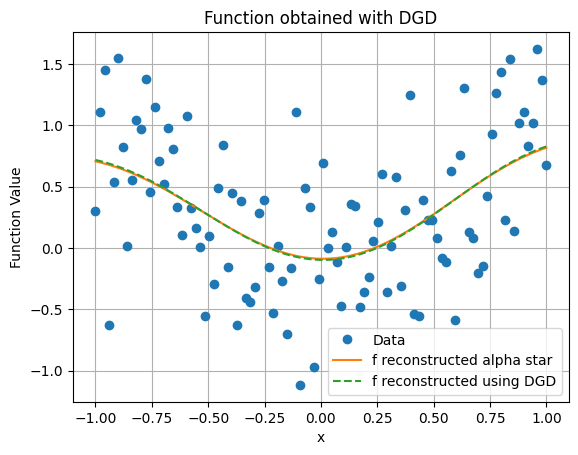

In [270]:
nt = 250
title = 'Function obtained with DGD'
method = 'DGD'
plot_f(nt, alpha_dgd, title, method)

<h2> Plot optimality gap

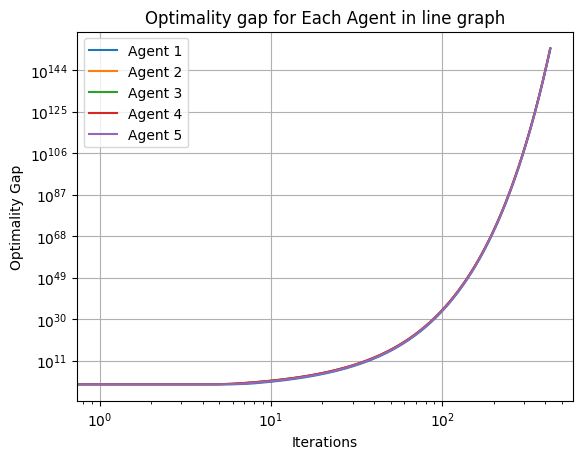

In [214]:
plt.figure()

for agent_idx in range(a):
    plt.loglog(range(num_iterations), opt_gap_dgd[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iterations")
plt.ylabel("Optimality Gap")
plt.title("Optimality gap for Each Agent in line graph")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Gradient tracking

In [34]:
def gradient_tracking(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star):
    
    nb_agents = len(agents) # Number of agents at play
    m = len(ind)
    opt_gap = np.zeros((num_iterations, nb_agents))

    alpha = np.random.normal(size=(nb_agents, m)) # randomly initialize the value of alpha
    
    g_k = alpha.copy()
    for a in range(nb_agents):
        g_k[a] = compute_local_gradient(alpha[a], a, sigma, y, K, ind, agents)
    
    for k in range(num_iterations):

        new_alpha = alpha.copy()
        new_alpha = w@alpha - learning_rate*g_k

        # communicate
        new_g = W@g_k
        #Update
        for a in range(nb_agents):
            grad_k_plus_1 = compute_local_gradient(new_alpha[a],a,sigma,y,K,ind,agents)
            grad_k = compute_local_gradient(alpha[a],a,sigma,y,K,ind,agents)
            new_g[a] += grad_k_plus_1 - grad_k
        
        alpha = new_alpha.copy()
        g_k = new_g.copy()
        opt_gap[k] = np.linalg.norm(alpha - alpha_star,axis=1)
        
    return alpha, opt_gap

In [35]:
num_iterations = 10000
learning_rate = 0.001
K = matrix_K(x[:n],x[:n])
alpha_gt, opt_gap_gt = gradient_tracking(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star)

In [36]:
alpha_gt = np.mean(alpha_gt,axis=0)

In [37]:
alpha_gt

array([-0.45965158,  0.74747866,  0.24485328,  0.46401889, -0.52072523,
        0.09766658, -0.51991022,  0.27218495,  0.93161311, -0.19591344])

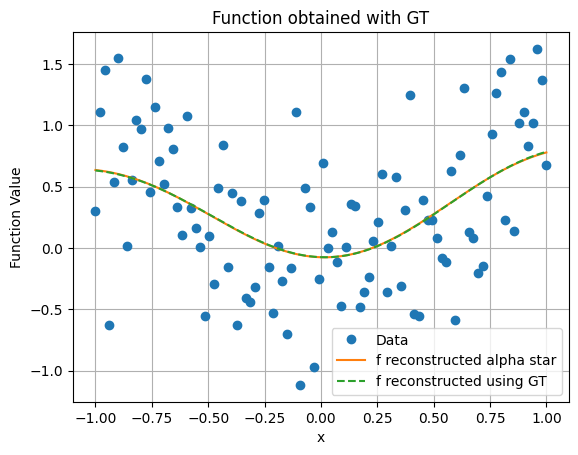

In [38]:
nt = 250
title = 'Function obtained with GT'
method = 'GT'
plot_f(nt, alpha_gt, title, method)

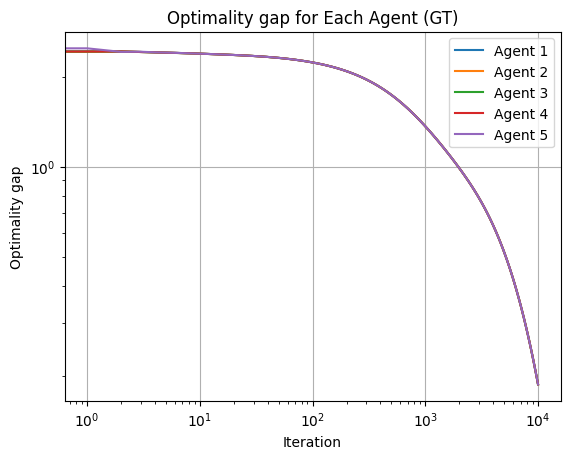

In [39]:

plt.figure()

for agent_idx in range(a):
    plt.loglog(range(num_iterations), opt_gap_gt[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimality gap")
plt.title("Optimality gap for Each Agent (GT)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

<h2> Dual Decomposition

In [133]:
def dual_decomposition(num_iterations, agents, ind, K, y, step_size, sigma, regularization, alpha_star):
    nb_agents = len(agents)
    m = len(ind)

    # Initialize dual variables and local optimization variables
    dual_variables = np.random.normal(size=(nb_agents, nb_agents, m))
    alpha = np.random.normal(size=(nb_agents, m))
    # Initialize optimality gap
    opt_gap = np.zeros((num_iterations, nb_agents))

    for k in range(num_iterations):

        for a in range(nb_agents):
            # Compute matrices A and vectors b for solving the local optimization problem
            Kmm = K[ind,:][:,ind]
            somme = np.zeros(Kmm.shape)
            
            for i in agents[a]:
                Kim = K[i,:][ind]
                somme += Kim.reshape(m, 1) @ Kim.reshape(1, m)
            
            A = Kmm / 5 + somme / (sigma ** 2) + 2 * regularization * np.eye(m)
            
            # Compute vector b_1
            b_1 = np.zeros_like(alpha[a])
            for i in agents[a]:
                Kim = K[i,:][M]
                b_1 += y[i] * Kim.T
                
            # Compute vector b_2 by sending x_i*(lambda_k) to the neighbors
            b_2 = np.zeros_like(alpha[a])
            for b in range(nb_agents):
                if (W[a][b] != 0) and (b < a):
                    b_2 += dual_variables[a, b]
                elif (W[a][b] != 0) and (a < b):
                    b_2 -= dual_variables[b, a]
            
            # Solve the linear system to update alpha
            alpha[a] = np.linalg.solve(A, b_1 / (sigma ** 2) - b_2)

        # Update dual variables lambda
        for i in range(nb_agents):
            for j in range(0, i):
                dual_variables[i, j] += step_size * (alpha[i] - alpha[j])

        # Compute optimality gap for each agent
        for a in range(nb_agents):
            opt_gap[k, a] = np.linalg.norm((alpha[a] - alpha_star))

    return alpha, opt_gap, dual_variables

In [134]:
regularization = 0.1
num_iterations = 10000
learning_rate = 0.001
K = matrix_K(x[:n],x[:n])

alpha_dd, opt_gap_dd, z = dual_decomposition(num_iterations, agents, ind, K, y[:n], step_size, sigma, regularization, alpha_star)
#alpha_dd, opt_gap_dd = dual_decomposition(num_iterations, agents, ind, w, K, y[:n], learning_rate, sigma, regularization)

[[ 1.16056333 -0.76716423  0.08710948 -0.87922078  0.39361647  3.66227778
  -1.38316308 -1.02536206  0.44455331  0.72140884]
 [ 1.02771645 -0.59302638 -0.66357236  1.17200085  1.54383271 -1.20634225
  -1.70570585 -0.72670183 -0.24945254 -0.35135124]
 [-0.70209487 -0.99801334  2.02257963  1.18096741 -1.28528864  0.04275644
  -0.15520769  0.14467075 -1.7781049   0.90828253]
 [-0.53012879 -0.05474882 -0.50732092 -0.30123295 -1.23125446 -0.93811217
  -1.27182047 -1.84592637 -0.60456263 -1.4150344 ]
 [ 0.04527059  0.00469249 -3.12385679  0.85871078 -0.01276162 -0.36114492
  -0.65864283  0.12607523 -0.41854605  1.29440688]]


In [135]:
alpha_dd = np.mean(alpha_dd, axis = 0)

In [136]:
alpha_dd

array([-0.60649699,  0.84932426,  0.33435562,  0.59005372, -0.53601637,
        0.11823894, -0.5911166 ,  0.28204764,  0.95463558, -0.23772371])

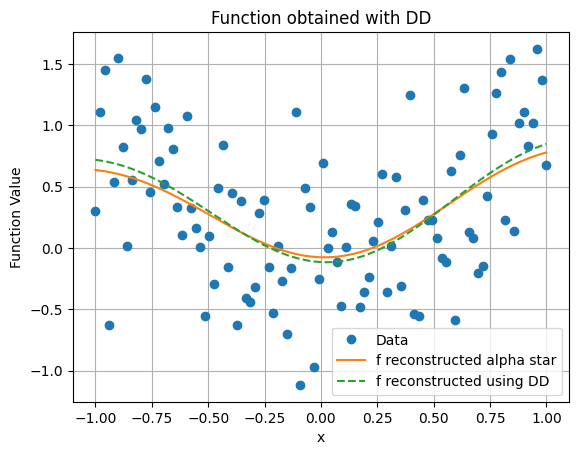

In [137]:
nt = 250
title = 'Function obtained with DD'
method = 'DD'
plot_f(nt, alpha_dd, title, method)

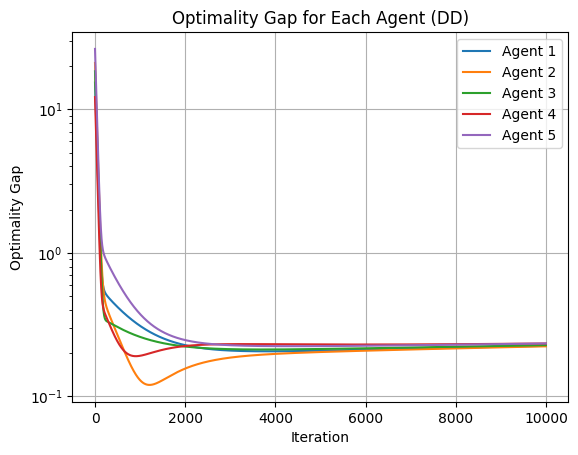

In [138]:
plt.figure()

for agent_idx in range(a):
    plt.plot(range(num_iterations), opt_gap_dd[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimality Gap")
plt.title("Optimality Gap for Each Agent (DD)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

<h2> Alternating Direction Method of Multipliers(ADMM)

In [140]:
def ADMM(num_iterations, agents, ind, K, y, sigma, beta):
    nb_agents = len(agents)
    m = len(ind)

    # Initialize variables
    #alpha = np.zeros((nb_agents, m))  # Local optimization variables
    alpha = np.random.normal(size = (nb_agents, m))
    print(alpha)
    opt_gap = np.zeros((num_iterations, m))
    dual_vars = np.zeros((nb_agents, m))  # Dual variables

    # Main loop for ADMM iterations
    for k in range(num_iterations):
        # Update alpha for each agent
        for a in range(nb_agents):
            # Compute matrices A_1 and A_2 for solving the local optimization problem
            Kmm = K[ind, :][:, ind]  # Subset of kernel matrix corresponding to local data

            sum_matrix = np.zeros_like(Kmm)
            for i in agents[a]:
                Ki_m = K[i, :][ind]
                sum_matrix += Ki_m.reshape(m, 1) @ Ki_m.reshape(1, m)

            A = Kmm / 5 + sum_matrix / (sigma ** 2) + beta * np.eye(m)

            # Compute vector b for solving the linear system
            b = np.zeros_like(alpha[a])
            for i in agents[a]:
                Ki_m = K[i, :][ind]
                b += y[i] * Ki_m.T

            # Solve the linear system to update alpha
            alpha[a] = np.linalg.solve(A, b / (sigma ** 2) + beta * np.sum(dual_vars, axis=0) / nb_agents)

        # Update dual variables
        for i in range(nb_agents):
            dual_vars[i] = np.mean(alpha, axis=0)

        # Compute optimality gap
        opt_gap[k] = np.linalg.norm(alpha - alpha_star)

    return alpha, opt_gap

In [141]:
num_iterations = 1000
beta = 300
regularization = 0.1
rho = 1
K = matrix_K(x[:n],x[:n])
alpha_admm, opt_gap_admm = ADMM(num_iterations, agents, ind, K, y, sigma, beta)

[[ 0.49771619  0.79988515  1.01552356 -2.11009774 -1.20460857  0.10425106
   1.21600181 -0.25999259  0.04671262  1.13581365]
 [ 0.94124421  0.46286282  0.31759388  0.29085457 -1.88374928  1.2347518
   0.00533975  0.10307436 -1.40710606 -0.31066545]
 [ 0.69050883  0.35149011  0.64636259 -1.70077693  1.46544988 -1.09723977
   0.36118945  1.51969837 -0.98636627 -1.25787744]
 [ 0.96022007 -0.37845773  0.31881695  0.26537324 -0.58082591  0.25660182
  -0.14042071 -0.54196184  0.19639546  0.81782237]
 [-0.16357351 -0.39947591 -0.52687083  0.42358534 -0.57841537 -1.33360828
  -0.92395241 -2.16362089  0.65024806  0.70106688]]


In [142]:
alpha_admm

array([[-0.6677705 ,  0.91711753,  0.36752299,  0.64351357, -0.58596443,
         0.14272212, -0.6494947 ,  0.31097102,  1.01372019, -0.25804286],
       [-0.66127223,  0.91166328,  0.36587174,  0.65444095, -0.57846009,
         0.15252125, -0.64254297,  0.30969542,  1.02537708, -0.25556443],
       [-0.66804421,  0.91985116,  0.37077032,  0.63994871, -0.5875401 ,
         0.1391221 , -0.65034064,  0.31422264,  1.01060412, -0.25538154],
       [-0.66910299,  0.90217904,  0.35292742,  0.66350752, -0.58219019,
         0.15873709, -0.64867322,  0.29651359,  1.03533901, -0.26955769],
       [-0.6836117 ,  0.90571418,  0.35476385,  0.63334195, -0.60153241,
         0.13019756, -0.66528523,  0.29806827,  1.00545904, -0.27250407]])

In [143]:
alpha_admm = np.mean(alpha_admm,axis=0)


In [144]:
alpha_admm

array([-0.66996032,  0.91130504,  0.36237126,  0.64695054, -0.58713744,
        0.14466002, -0.65126735,  0.30589419,  1.01809989, -0.26221012])

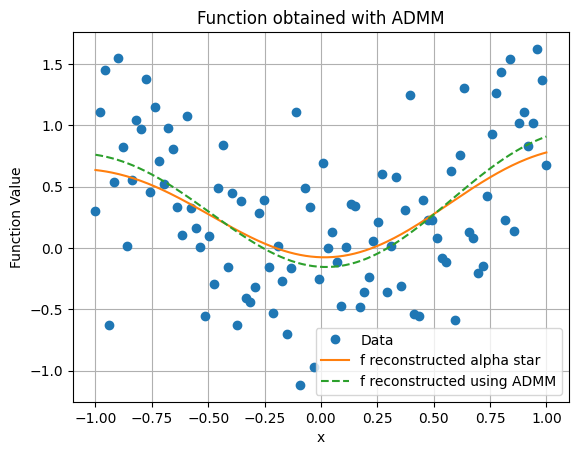

In [145]:
nt = 250
title = 'Function obtained with ADMM'
method = 'ADMM'
plot_f(nt, alpha_admm, title, method)

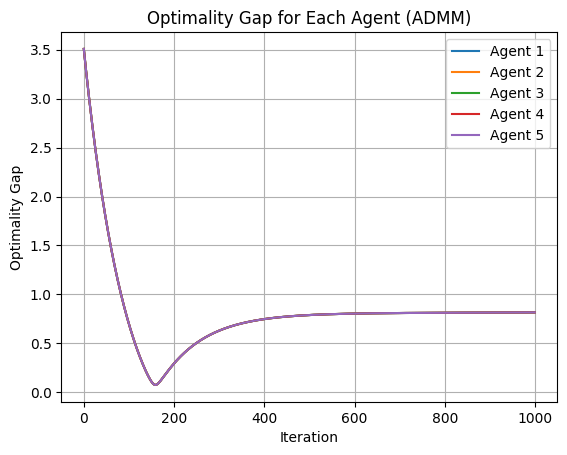

In [146]:
plt.figure()

for agent_idx in range(a):
    plt.plot(range(num_iterations), opt_gap_admm[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimality Gap")
plt.title("Optimality Gap for Each Agent (ADMM)")
plt.legend()
plt.grid(True)
plt.show()